# RO change over time

## Imports

In [41]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import src.XRO
import copy
import scipy.stats
import warnings
import calendar
import gsw

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [42]:
def get_ensemble_fits_over_time(
    data,
    model,
    ac_mask_idx,
    mask_NT,
    window_size=480,
    step_size=60,
    by_ensemble_member=True,
):
    """Get RO fits for each ensemble member as a function of time.
    Args:
        window_size: size of sliding window (units: months)
        step_size: how many months to slide the window between each calculation
    """

    ## Get number of timesteps in data
    n = len(data.time)

    ## empty list to hold results and dates
    fits_by_year = []
    start_dates = []

    ## loop through rolling windows
    for j, i in enumerate(tqdm.tqdm(np.arange(0, n - step_size, step_size))):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = data.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## get parameter fit
            if by_ensemble_member:
                _, fits = src.utils.get_RO_ensemble(
                    data_subset,
                    # T_var=T_var,
                    # h_var=h_var,
                    model=model,
                    ac_mask_idx=ac_mask_idx,
                )

            else:
                with warnings.catch_warnings(action="ignore"):
                    fits = model.fit_matrix(
                        data_subset,
                        ac_mask_idx=ac_mask_idx,
                        maskNT=mask_NT,
                    )

            ## drop X,Y,time variables
            fits = fits.drop_vars(["X", "Y", "Yfit", "time"])
            fits_by_year.append(fits)

    ## convert from list to xarray
    start_dates = xr.concat(start_dates, dim="time")
    fits_by_year = xr.concat(fits_by_year, dim=start_dates)

    return fits_by_year


def update_time_coord(data, window_size=480):
    """change time coordinate to center of period used for computing stats"""

    ## get year corresponding to start of period
    year = copy.deepcopy(data.time.dt.year.values)

    ## update to midpoint of period
    year_shift = int(window_size / 12 / 2)
    year += year_shift

    ## update coordinate
    data = data.assign_coords({"time": year}).rename({"time": "year"})

    ## trim to end in 2080
    data = data.sel(year=slice(None, 2080))

    return data


def get_params(fits, model):
    """Get parameters from fits dataarray"""

    ## get parameters from fits
    params = model.get_RO_parameters(fits)

    ## get normalized noise stats
    fix_coords = lambda x: x.assign_coords({"cycle": params.cycle})
    params["xi_T_norm"] = fix_coords(fits["normxi_stdac"].isel(ranky=0))
    params["xi_h_norm"] = fix_coords(fits["normxi_stdac"].isel(ranky=1))

    return params


def get_rolling_std(data, n=20):
    """
    Get standard deviation, computing over time and ensemble member. To increase
    sample size for variance estimate, compute over time window of 2n+1
    years, centered at given year.
    """

    ## do the computation
    kwargs = dict(fn=np.std, n=n, reduce_ensemble_dim=False)
    data_std = src.utils.get_rolling_fn_bymonth(data, **kwargs)

    ## unstack year and month
    data_std = src.utils.unstack_month_and_year(data_std)

    return data_std

## Load data

In [43]:
## open data
Th = src.utils.load_cesm_indices()

## rename indices for convenience
Th = Th.rename(
    {
        "north_tropical_atlantic": "natl",
        "atlantic_nino": "nino_atl",
        "tropical_indian_ocean": "iobm",
        "indian_ocean_dipole": "iod",
        "north_pacific_meridional_mode": "npmm",
        "south_pacific_meridional_mode": "spmm",
    }
)

## standardize (for convenience)
Th /= Th.std()

## Compute time-varying RO parameters

In [44]:
## specify variables names
varnames = ["T_34", "h_w"]

# ## specify args for model fit
kwargs = dict(
    model=src.XRO.XRO(ncycle=12, ac_order=3, is_forward=True),
    ac_mask_idx=None,
    window_size=480,
    step_size=120,
    mask_NT=[],
)

## Get fits
fits_v2 = get_ensemble_fits_over_time(Th[varnames], by_ensemble_member=False, **kwargs)

## expand "ensemble dim" to match rest of script
fits_v2 = update_time_coord(
    fits_v2.expand_dims("member"), window_size=kwargs["window_size"]
)

## extract parameters
params_v2 = get_params(fits=fits_v2, model=kwargs["model"])

## get change from initial period
delta_params_v2 = params_v2 - params_v2.isel(year=1)

100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


## Validate changes in variance over time

### Estimate variance of RO model over time

In [45]:
def get_RO_sigma(model, params, **simulation_kwargs):
    """Compute stats (e.g., standard deviation) for RO parameters over time"""

    output = model.simulate(fit_ds=params.mean("member"), **simulation_kwargs)

    return output.groupby("time.month").std()


def get_RO_sigma_over_time(model, params, **simulation_kwargs):
    """Compute stats over time"""

    ## empty list to hold result
    sigmas = []

    ## loop through years
    for y in tqdm.tqdm(params.year):

        ## specs for simulation
        kwargs = dict(
            simulation_kwargs,
            model=model,
            params=params.sel(year=y),
        )

        ## do the simulation
        sigmas.append(get_RO_sigma(**kwargs))

    ## put back in xarray
    sigmas = xr.concat(sigmas, dim=params.year)

    return sigmas

In [46]:
## simulation specs
simulation_kwargs = dict(
    nyear=40,
    ncopy=50,
    seed=1000,
    X0_ds=Th[varnames].isel(member=0, time=0),
    noise_type="white",
)

## compute with parameters estimated from all ensemble members
RO_sigma_over_time_v2 = get_RO_sigma_over_time(
    model=kwargs["model"], params=fits_v2, **simulation_kwargs
)

100%|██████████| 22/22 [00:06<00:00,  3.62it/s]


### estimate variance of CESM over time

In [47]:
## compute rolling std
Th_std = get_rolling_std(Th, n=20)

## compute percentage change in std
baseline = Th_std.isel(year=0).mean("member")
delta_Th_std = 100 * (Th_std - baseline) / baseline

### Compare model and RO

Function to plot results

In [48]:
def plot_stats_comp(ax, list_of_stats, labels, colors=None, n=varnames[0]):
    """plot comparison of variance over time"""

    if colors is None:
        colors = sns.color_palette()[: len(list_of_stats)]

    for stats, label, c in zip(list_of_stats, labels, colors):

        ## plot median
        mplot = ax.plot(stats.year, stats[n].sel(q=0.5), lw=2.5, label=label, c=c)

        ## plot lower/upper quantiles
        kwargs = dict(c=mplot[0].get_color(), lw=0.8)
        for q in stats.q:
            if q != 0.5:
                ax.plot(stats.year, stats[n].sel(q=q), **kwargs)

    ## label and set plotting specs
    ax.set_xlabel("Year")
    ax.set_ylabel(r"$\sigma_T$ ($^{\circ}$C)")
    ax.set_ylim([0.3, 1.7])
    ax.set_xticks([1870, 1975, 2080])
    ax.set_yticks([0.6, 1.2])

    return

Make the plot

/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


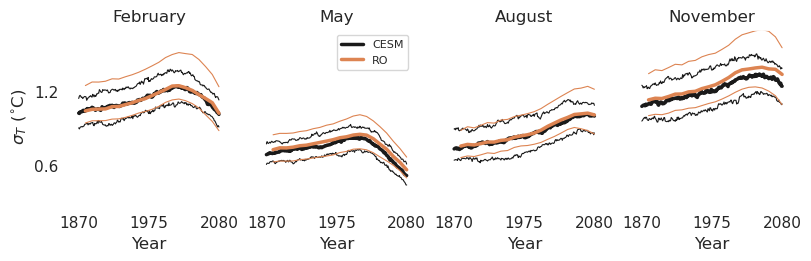

In [49]:
## specify function to reduce over months
sel_fn = lambda x, m: x.sel(month=m)

## specify function to compute bounds
get_stats = (
    lambda x, m: sel_fn(x, m)
    .quantile(q=[0.1, 0.5, 0.9], dim="member")
    .rename({"quantile": "q"})
)

fig, axs = plt.subplots(1, 4, figsize=(8, 2.5), layout="constrained")

for i, (ax, m) in enumerate(zip(axs, [2, 5, 8, 11])):

    ## compute stats
    stats_mpi = get_stats(Th_std, m=m)
    stats_ro_v2 = get_stats(RO_sigma_over_time_v2, m=m)

    ## first, MPI vs RO
    plot_stats_comp(
        ax,
        [stats_mpi, stats_ro_v2],
        labels=["CESM", "RO"],
        colors=["k", sns.color_palette()[1]],
        n=varnames[0],
    )

    ax.set_title(calendar.month_name[m])
    if i > 0:
        ax.set_yticks([])
        ax.set_ylabel(None)


axs[1].legend(prop=dict(size=8))

plt.show()

## Plot diagnostics

### Hovmoller plots for variance, growth rate, and noise

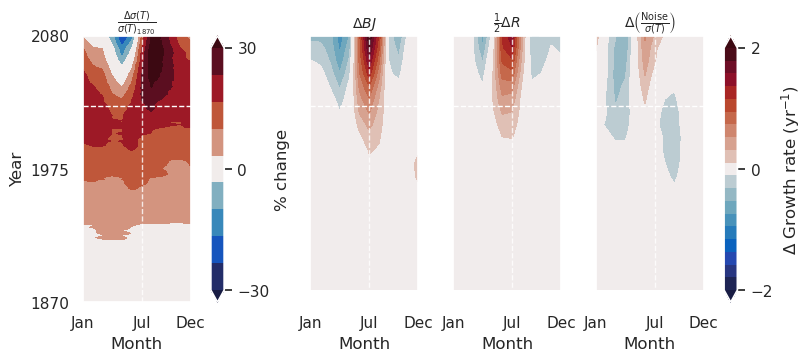

In [50]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5), layout="constrained")

#### plot change in std dev
plot_kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(30, 6), extend="both"
)

## plot data
cp0 = axs[0].contourf(
    delta_Th_std.month,
    delta_Th_std.year,
    delta_Th_std[varnames[0]].mean("member"),
    **plot_kwargs
)

##### plot change in model params

## specify plotting specs
plot_kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(2, 0.2), extend="both"
)

## plot data
cp1 = axs[1].contourf(
    params_v2.cycle,
    params_v2.year,
    delta_params_v2["BJ_ac"].mean("member"),
    **plot_kwargs
)
cp2 = axs[2].contourf(
    params_v2.cycle,
    params_v2.year,
    0.5 * delta_params_v2["R"].mean("member"),
    **plot_kwargs
)
cp3 = axs[3].contourf(
    params_v2.cycle,
    params_v2.year,
    delta_params_v2["xi_T_norm"].mean("member"),
    **plot_kwargs
)

## set ticks and add guideline
for ax in axs:
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.axvline(7, c="w", ls="--", lw=1, alpha=0.8)
    ax.set_xlabel("Month")
    ax.axhline(2025, c="w", ls="--", lw=1)

## add colorbar
cb0 = fig.colorbar(cp0, label=r"% change", ticks=[-30, 0, 30])
cb1 = fig.colorbar(cp3, label=r"$\Delta$ Growth rate (yr$^{-1}$)", ticks=[-2, 0, 2])

## label
axs[0].set_ylabel("Year")
axs[0].set_yticks([1870, 1975, 2080])
axs[0].set_title(r"$\frac{\Delta \sigma(T)}{\sigma(T)_{1870}}$", size=10)
axs[1].set_title(r"$\Delta BJ$", size=10)
axs[2].set_title(r"$\frac{1}{2}\Delta R$", size=10)
axs[3].set_title(r"$\Delta\left(\frac{\text{Noise}}{\sigma(T)}\right)$", size=10)
for ax in axs[1:]:
    ax.set_yticks([])
    ax.set_ylim(axs[0].get_ylim())

plt.show()

### Change in ensemble-mean parameters over time

Plotting funcs

In [51]:
def plot_curve(ax, x, **plot_kwargs):
    """plot change in parameter over time on given ax"""
    plot_data = ax.plot(x.year, x, lw=2, **plot_kwargs)

    return plot_data


def plot_param_change_over_time(ax, dp):
    """Plot change in parameters over time on ax object. 'dp' is change in params"""

    ## annual mean over time
    ax.axhline(0, c="k", ls="-", lw=0.5)

    ## Plot Bjerknes growth rate
    plot_curve(ax, dp["BJ_ac"].mean("cycle"), c="k", label=r"$\overline{BJ}$")
    plot_curve(ax, dp["BJ_ac"].sel(cycle=7), c="k", ls="--", label="$BJ_{Jul}$")

    ## Plot R
    R_plot = plot_curve(ax, dp["R"].mean("cycle"), label=r"$\overline{R}$")
    kwargs = dict(c=R_plot[0].get_color(), ls="--", label=r"$R_{Jul}$")
    plot_curve(ax, dp["R"].sel(cycle=6), **kwargs)

    ## plot epsilon
    plot_curve(ax, -dp["epsilon"].mean("cycle"), label=r"$-\varepsilon$")

    ## plot noise
    plot_curve(
        ax,
        dp["xi_T_norm"].mean("cycle"),
        label=r"$\xi_T/\sigma_T$",
        c="darkgray",
        # ax,
        # dp["xi_T_norm"].sel(cycle=7),
        # label=r"$\xi_T/\sigma_T$",
        # c="darkgray",
    )
    plot_curve(
        ax, dp["xi_h_norm"].mean("cycle"), label=r"$\xi_h/\sigma_h$", c="lightgray"
    )

    ## set axis specs
    ax.set_xlim([None, None])
    ax.legend(prop=dict(size=6), loc="upper left")
    ax.set_xticks([1870, 1975, 2080])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_ylabel(r"year$^{-1}$")
    ax.set_xlabel("Year")
    ax.set_title(r"$\Delta \left(\text{RO parameters}\right)$")

    return

Make plot

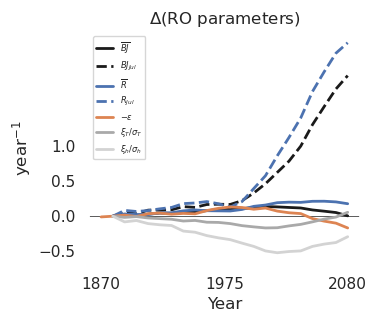

In [52]:
fig, ax = plt.subplots(figsize=(3.5, 3))

## plot change over time of parameters
# plot_param_change_over_time(ax, dp=delta_params.mean("member"))
plot_param_change_over_time(ax, dp=delta_params_v2.mean("member"))

plt.show()

## Sensitivity tests
Is noise or BJ index driving changes?

In [53]:
def get_perturbed_params(params, name):
    """get version of parameters where specified parameter
    is fixed to its starting value"""

    ## copy of params to hold perturbed values
    pparams = copy.deepcopy(params)

    ## get initial value of parameter and broadcast it to correct shape
    x0 = params[name].isel(year=1) * xr.ones_like(params[name])

    ## transpose dims to make sure they match
    x0 = x0.transpose(*params[name].dims)

    ## update parameters
    pparams[name].values = x0

    return pparams


def get_perturbed_BJ(params):
    """fix values of R and epsilon in parameter set"""

    ## initialize empty array to hold parameters
    pparams = copy.deepcopy(params)

    ## get copy of linear operator
    Lac = pparams["Lac"].transpose("year", "ranky", "rankx", ...)
    R0 = Lac.values[1:2, 0, 0]
    eps0 = Lac.values[1:2, 1, 1]

    ## update Lac
    Lac.values[:, 0, 0] = R0
    Lac.values[:, 1, 1] = eps0
    pparams["Lac"] = Lac

    return pparams


def get_perturbed_R(params):
    """fix values of R parameter set"""

    ## initialize empty array to hold parameters
    pparams = copy.deepcopy(params)

    ## get copy of linear operator
    Lac = pparams["Lac"].transpose("year", "ranky", "rankx", ...)
    R0 = Lac.values[1:2, 0, 0]

    ## update Lac
    Lac.values[:, 0, 0] = R0
    pparams["Lac"] = Lac

    return pparams


def get_perturbed_R_cyc(params):
    """fix values of R parameter set"""

    ## initialize empty array to hold parameters
    pparams = copy.deepcopy(params)

    ## get copy of linear operator
    Lac = pparams["Lac"].transpose("year", "ranky", "rankx", ..., "cycle")
    R = Lac.values[:, 0, 0]
    R_mean = R.mean(-1, keepdims=True)
    Lac.values[:, 0, 0] = R * R_mean[1] / R_mean

    ## update Lac
    pparams["Lac"] = Lac

    return pparams


def get_perturbed_F2(params):
    """fix values of F2 in parameter set"""

    ## initialize empty array to hold parameters
    pparams = copy.deepcopy(params)

    ## get copy of linear operator
    Lac = pparams["Lac"].transpose("year", "ranky", "rankx", ...)
    F2 = Lac.values[1:2, 1, 0]

    ## update Lac
    Lac.values[:, 1, 0] = F2
    pparams["Lac"] = Lac

    return pparams


def get_perturbed_Lac(params):
    """fix values of R and epsilon in parameter set"""

    ## initialize empty array to hold parameters
    pparams = copy.deepcopy(params)

    ## get copy of linear operator
    Lac = pparams["Lac"].transpose("year", "ranky", "rankx", ...)

    ## perturb core RO
    L0 = Lac.values[1:2, :2, :2]
    Lac.values[:, :2, :2] = L0

    # ## perturb PMM effect on RO
    # L0 = Lac.values[1:2, :2, 2:]
    # Lac.values[:,:2, 2:] = L0

    pparams["Lac"] = Lac

    return pparams


def get_perturbed_xi(params, ranky):
    """fix values of R and epsilon in parameter set"""

    ## initialize empty array to hold parameters
    pparams = copy.deepcopy(params)

    ## get copy of linear operator
    for n in ["xi_std", "xi_stdac"]:
        xi = pparams[n].transpose("year", "ranky", ...)
        xi0 = xi.values[1:2, ranky]

        ## update matrix
        xi.values[:, ranky] = xi0
        pparams[n] = xi

    return pparams

Get perturbed parameters and plot

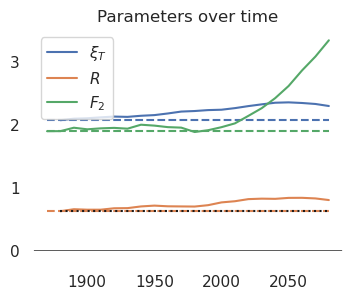

In [54]:
## get parameters with fixed noise
params_fixed_noise = get_perturbed_params(fits_v2, "xi_stdac")
params_fixed_noise = get_perturbed_params(params_fixed_noise, "xi_std")

## next, fix R
params_fixed_R = get_perturbed_R(fits_v2)

## next, fix R's annual mean value
params_fixed_R_cyc = get_perturbed_R_cyc(fits_v2)

## next, fix F2
params_fixed_F2 = get_perturbed_F2(fits_v2)

## functions to extract data for plotting
sel_fn = lambda x: x.mean(["member", "cycle"])
sel_noise = lambda x: sel_fn(x)["xi_stdac"].isel(ranky=0)
sel_BJ = lambda x: kwargs["model"].get_RO_parameters(sel_fn(x))["BJ_ac"]
sel_R = lambda x: kwargs["model"].get_RO_parameters(sel_fn(x))["R"]
sel_F2 = lambda x: kwargs["model"].get_RO_parameters(sel_fn(x))["F2"]

## set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot noise
c = sns.color_palette()[0]
ax.plot(params_fixed_noise.year, sel_noise(fits_v2), c=c, label=r"$\xi_T$")
ax.plot(params_fixed_noise.year, sel_noise(params_fixed_noise), c=c, ls="--")

## plot R
c = sns.color_palette()[1]
ax.plot(params_fixed_R.year, sel_R(fits_v2), c=c, label=r"$R$")
ax.plot(params_fixed_R.year, sel_R(params_fixed_R), c=c, ls="--")
ax.plot(params_fixed_R_cyc.year, sel_R(params_fixed_R_cyc), c="k", ls=":")

## plot F2
c = sns.color_palette()[2]
ax.plot(params_fixed_F2.year, sel_F2(fits_v2), c=c, label=r"$F_2$")
ax.plot(params_fixed_F2.year, sel_F2(params_fixed_F2), c=c, ls="--")

## label
ax.legend()
ax.set_title(r"Parameters over time")
ax.axhline(0, lw=0.5, c="k")

plt.show()

Run simulations with perturbed parameters

In [55]:
## compute with parameters estimated from all ensemble members
RO_sigma_over_time_fixed_noise = get_RO_sigma_over_time(
    model=kwargs["model"], params=params_fixed_noise, **simulation_kwargs
)

RO_sigma_over_time_fixed_R = get_RO_sigma_over_time(
    model=kwargs["model"], params=params_fixed_R, **simulation_kwargs
)

RO_sigma_over_time_fixed_R_cyc = get_RO_sigma_over_time(
    model=kwargs["model"], params=params_fixed_R_cyc, **simulation_kwargs
)

RO_sigma_over_time_fixed_F2 = get_RO_sigma_over_time(
    model=kwargs["model"], params=params_fixed_F2, **simulation_kwargs
)

100%|██████████| 22/22 [00:05<00:00,  3.71it/s]


Plot results

In [56]:
## load mixed layer depth EOFs
MLD_EOFS = src.utils.load_eofs(pathlib.Path(DATA_FP, "cesm", "eofs_mlotst.nc"))


def get_H(t_bnds):
    """get Niño 3.4 MLD for given bounds"""

    ## get scores in given subset of data
    scores_ = MLD_EOFS.scores().isel(time=slice(*t_bnds)).mean("member")

    ## get clim
    scores_clim = scores_.groupby("time.month").mean()

    ## reconstruct nino MLD
    mld = src.utils.reconstruct_fn(
        scores=scores_clim, components=MLD_EOFS.components(), fn=src.utils.get_nino34
    )

    return mld.rename({"month": "cycle"})


## get forced component
scores_mean = MLD_EOFS.scores().mean("member")

## compute MLD
H = src.utils.reconstruct_fn(
    scores=scores_mean.isel(time=slice(None, -1)),
    components=MLD_EOFS.components(),
    fn=src.utils.get_nino34,
)

## sep month/year
H = src.utils.unstack_month_and_year(H)

## smooth
H = H.rolling({"year": 31}, center=True).mean()
H = H.isel(year=slice(15, -15))

## get inverse MLD
beta = 1 / H

/glade/u/home/kcarr/RO-change-over-time/src/utils.py:846: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'time' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  data_["time"] = new_idx


In [57]:
## specify months
month_range = slice(4, 5)

## get F2 and eps
F2 = -fits_v2.Lac.isel(rankx=0, ranky=1).mean("member")
eps = -fits_v2.Lac.isel(rankx=1, ranky=1).mean("member")
R = fits_v2.Lac.isel(rankx=0, ranky=0).mean("member")

## subset for months
beta_ = beta.isel(month=month_range).mean("month")
F2_ = F2.isel(cycle=month_range).mean("cycle")
eps_ = eps.isel(cycle=month_range).mean("cycle")
R_ = R.isel(cycle=slice(4, 5)).mean("cycle")

## get fractional change
get_delta = lambda x: (x - x.isel(year=1)) / x.isel(year=1)
delta_beta = get_delta(beta_)
delta_F2 = get_delta(F2_)
delta_eps = get_delta(eps_)
delta_R = get_delta(R_)

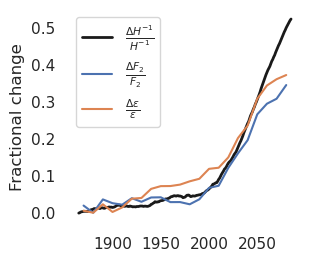

In [58]:
fig, ax = plt.subplots(figsize=(3, 2.5), layout="constrained")

## plot data
ax.plot(
    delta_beta.year, delta_beta, label=r"$\frac{\Delta H^{-1}}{H^{-1}}$", c="k", lw=2
)
ax.plot(delta_F2.year, delta_F2, label=r"$\frac{\Delta F_2}{F_2}$")
ax.plot(delta_eps.year, delta_eps, label=r"$\frac{\Delta \varepsilon}{\varepsilon}$")
# ax.plot(delta_R.year, delta_R*.25, label=r"$\frac{\Delta R}{R}$")

## label
ax.set_ylabel("Fractional change")


ax.legend()
plt.show()

In [59]:
## get Niño 3.4 mean
Th_forced = xr.open_dataset(DATA_FP / "cesm" / "Th_emean.nc")
T34 = Th_forced["T_34"].groupby("time.year").mean().isel(year=slice(None, -1))
T34 = T34.rolling({"year": 15}, center=True).mean().isel(year=slice(7, -7))

In [60]:
n_year = len(T34.year)
sa = 10 * np.ones(n_year)
p = 0 * np.ones(n_year)
alpha = gsw.alpha(SA=sa, CT=T34.values, p=p)
dalpha = (alpha - alpha[0]) / alpha[0]

/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


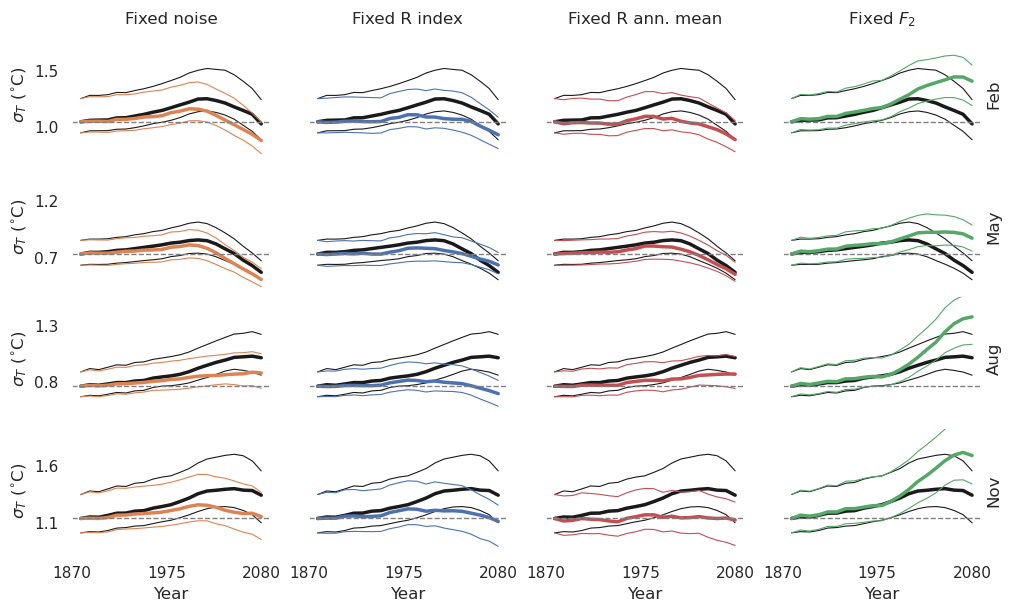

In [61]:
## specify function to compute bounds
get_stats = (
    lambda x, m: x.sel(month=m)
    .quantile(q=[0.1, 0.5, 0.9], dim="member")
    .rename({"quantile": "q"})
)

## plot results
fig, axs = plt.subplots(4, 4, figsize=(10, 6), layout="constrained")

for i, m in enumerate([2, 5, 8, 11]):

    ## compute stats
    stats_ro_v2 = get_stats(RO_sigma_over_time_v2, m=m)
    stats_fixed_noise = get_stats(RO_sigma_over_time_fixed_noise, m=m)
    stats_fixed_R = get_stats(RO_sigma_over_time_fixed_R, m=m)
    stats_fixed_R_cyc = get_stats(RO_sigma_over_time_fixed_R_cyc, m=m)
    stats_fixed_F2 = get_stats(RO_sigma_over_time_fixed_F2, m=m)

    ## first, fix noise
    plot_stats_comp(
        axs[i, 0],
        [stats_ro_v2, stats_fixed_noise],
        labels=["Control", "fixed noise"],
        colors=["k", sns.color_palette()[1]],
    )

    ## next, fix R
    plot_stats_comp(
        axs[i, 1],
        [stats_ro_v2, stats_fixed_R],
        labels=["Control", r"fixed $R$"],
        colors=["k", sns.color_palette()[0]],
    )

    ## next, fix R
    plot_stats_comp(
        axs[i, 2],
        [stats_ro_v2, stats_fixed_R_cyc],
        labels=["Control", r"fixed $R$ ann. mean"],
        colors=["k", sns.color_palette()[3]],
    )

    ## next, fix F2
    plot_stats_comp(
        axs[i, 3],
        [stats_ro_v2, stats_fixed_F2],
        labels=["Control", r"fixed $F_2$"],
        colors=["k", sns.color_palette()[2]],
    )

    ## get baseline value
    sigma0 = stats_ro_v2[varnames[0]].isel(q=1, year=1).values.item()

    ## label
    axs[i, 0].set_yticks([np.round(sigma0, 1), np.round(sigma0 + 0.5, 1)])
    axs[i, 1].set_ylabel(None)
    axs[i, 2].set_ylabel(None)
    axs[i, -1].set_ylabel(calendar.month_abbr[m])
    axs[i, -1].yaxis.set_label_position("right")
    for ax in axs[i]:
        ax.axhline(sigma0, c="gray", lw=1, ls="--")
        ax.set_ylim([sigma0 - 0.3, sigma0 + 0.8])

for ax in axs[:-1].flatten():
    ax.set_xticks([])
    ax.set_xlabel(None)

for ax in axs[:, 1:].flatten():
    ax.set_yticks([])

axs[0, 0].set_title("Fixed noise")
axs[0, 1].set_title("Fixed R index")
axs[0, 2].set_title("Fixed R ann. mean")
axs[0, 3].set_title(r"Fixed $F_2$")

plt.show()

### Predictability

1. Fit RO to (i) early and (ii) late data
2. Assess forecast skill in both (compare difference)
3. Perfect model forecasts with RO

#### Fit models

In [62]:
def calc_forecast_skill(fcst_ds, ref_ds, metric="acc", is_mv3=False):
    try:
        fcst_ds = fcst_ds.squeeze().drop("member")
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean("init")
        ref_mv3 = (
            ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim="time")
        )
    else:
        ref_mv3 = ref_ds

    ## hindcast
    hc_XRO = climpred.HindcastEnsemble(fcst_ds)
    hc_XRO = hc_XRO.add_observations(ref_mv3)

    ## compute skill
    skill_XRO = hc_XRO.verify(
        metric=metric,
        comparison="e2o",
        alignment="maximize",
        dim=["sample"],
        skipna=True,
        groupby="month",
    )

    ## not sure
    try:
        del skill_XRO.attrs["skipna"]
        skill_XRO = skill_XRO.drop("skill")
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != "model":
            skill_XRO[var].encoding["dtype"] = "float32"
            skill_XRO[var].encoding["_FillValue"] = 1e20

    return skill_XRO

In [63]:
## get early/late data
varnames = ["T_34", "h_w"]
Th0 = Th[varnames].isel(time=slice(12, 372))
Th1 = Th[varnames].isel(time=slice(-360, None))

## specify model
model = src.XRO.XRO(ncycle=12, ac_order=3, is_forward=True)

## fit model
fit_kwargs = dict(ac_mask_idx=None, maskNT=[])
fit0 = model.fit_matrix(Th0, **fit_kwargs)
fit1 = model.fit_matrix(Th1, **fit_kwargs)

#### Make forecasts

Function to get forecast data

In [64]:
def get_forecast_data(model, fit, data, max_lead=28, n_members=5):
    """Get forecasts and verification data for given model, fit, and data"""

    #### forecast data

    ## reshape for forecasting
    # data_ = data.isel(time=slice(None, -max_lead), member=slice(None, n_members))
    data_ = data.isel(member=slice(None, n_members))
    data_ = data_.stack(sample=["member", "time"]).transpose(..., "sample")

    ## make forecasts
    forecast = model.reforecast(
        fit_ds=fit,
        init_ds=data_,
        n_month=max_lead,
        ncopy=1,
        noise_type="zero",
    )

    ## massage into xarray
    forecast = forecast.swap_dims({"sample": "init"}).unstack("init")
    forecast = forecast.rename({n: f"{n}_hat" for n in list(forecast)})
    forecast = forecast.isel(time=slice(None, -max_lead))

    #### verification data

    ## get time index
    time_idx = forecast.time
    n_time = len(time_idx)

    ## loop thru lead times
    target = []
    for l in forecast.lead.values:

        target_ = data.sel(member=forecast.member).isel(time=slice(l, n_time + l))
        target_ = target_.assign_coords(dict(time=time_idx))
        target.append(target_)

    ## convert to xr
    target = xr.concat(target, dim=forecast.lead)

    return xr.merge([forecast, target])

Compute forecasts

In [65]:
## path to save pre-computed results
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"], "forecast_data")

## try loading pre-computed data
try:
    forecast_data0 = xr.open_dataset(SAVE_FP / "forecast_data0.nc")
    forecast_data1 = xr.open_dataset(SAVE_FP / "forecast_data1.nc")

## otherwise, compute and save
except:
    forecast_data0 = get_forecast_data(model=model, fit=fit0, data=Th0, n_members=100)
    forecast_data1 = get_forecast_data(model=model, fit=fit1, data=Th1, n_members=100)

    forecast_data0.to_netcdf(SAVE_FP / "forecast_data0.nc")
    forecast_data1.to_netcdf(SAVE_FP / "forecast_data1.nc")

#### Evaluate

Funcs to compute correlation

In [66]:
def get_corr(ds, varname):
    """Get correlation for given variable in dataset"""

    return xr.corr(ds[varname], ds[f"{varname}_hat"], dim=["member", "time"])


def get_corr_bymonth(ds, varname):
    """Get correlation by month for given variable in dataset"""

    return ds.groupby("time.month").map(get_corr, varname=varname)

Compute

In [67]:
## specify plot variable
plot_var = "h_w"

## compute
corr0 = get_corr_bymonth(forecast_data0, plot_var).sel(lead=slice(1, None))
corr1 = get_corr_bymonth(forecast_data1, plot_var).sel(lead=slice(1, None))

#### Plot difference

Plotting functions

In [68]:
def contourf_skill(ax, skill, **kwargs):
    """filled contour plot of correlation"""

    plot_data = ax.contourf(
        skill.lead,
        skill.month,
        skill,
        **kwargs,
    )

    return plot_data


def contour_cutoff(ax, skill, cutoff=0.5, **kwargs):
    """plot single contour to show cutoff"""

    plot_data = ax.contour(
        skill.lead,
        skill.month,
        skill,
        colors="k",
        levels=[cutoff],
        **kwargs,
    )

    return plot_data


def format_ax(ax):
    """make ax look nicer"""
    for ax in axs:
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])
        ax.set_ylabel("Init.")
        ax.set_xlim([None, 24.5])
    axs[-1].set_xticks([1, 8, 16, 24])
    axs[-1].set_xlabel("Lead")

    return

Make the plot

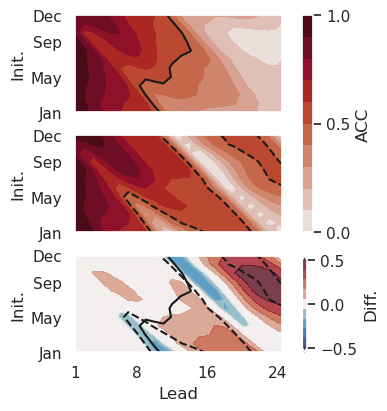

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(4, 4), layout="constrained")

for (
    ax,
    corr,
    ls,
) in zip(axs[:2], [corr0, corr1], ["solid", "dashed"]):

    ## plot
    plot_data0 = contourf_skill(ax, corr, cmap="cmo.amp", levels=np.arange(0, 1.1, 0.1))
    contour_cutoff(ax, corr, linestyles=ls)

## plot difference
plot_data_diff = contourf_skill(
    axs[-1],
    corr1 - corr0,
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(0.5, 0.1),
    extend="both",
    alpha=0.8,
)

## plot cutoffs
contour_cutoff(axs[-1], corr0, linestyles="solid")
contour_cutoff(axs[-1], corr1, linestyles="dashed")

fig.colorbar(plot_data0, ax=axs[:2], ticks=[0, 0.5, 1], label="ACC")
fig.colorbar(plot_data_diff, ax=axs[-1], ticks=[-0.5, 0, 0.5], label="Diff.")

## label
for ax in axs:
    format_ax(ax)

plt.show()

#### Composite evolution of $T$ and $h$

In [70]:
def get_samples(forecast_data, q=0.9, is_warm=True):
    """function to get quantile of samples from data"""

    ## get Dec. initial conditions and reshape
    data_dec = forecast_data.isel(time=forecast_data.time.dt.month == 9)
    data_dec = data_dec.stack(sample=["member", "time"])

    ## get indices to sort data
    T34_init = data_dec["T_34"].isel(lead=0).drop_vars("lead")

    ## select for quantile
    if is_warm:
        cutoff = T34_init.quantile(q=q)
        samples = data_dec.isel(sample=(T34_init >= cutoff))
    else:
        cutoff = T34_init.quantile(q=1 - q)
        samples = data_dec.isel(sample=(T34_init <= cutoff))

    return samples


## get trajectories in early/late period
warm0 = get_samples(forecast_data0, is_warm=True)
warm1 = get_samples(forecast_data1, is_warm=True)

cold0 = get_samples(forecast_data0, is_warm=False)
cold1 = get_samples(forecast_data1, is_warm=False)

In [71]:
def format_axs(axs):
    """format axs in preferred style"""
    for ax in axs[0, :]:
        ax.set_ylim([-2.5, 3])

    for ax in axs[1, :]:
        ax.set_ylim([-2.5, 4])

    for ax in axs[:, 1]:
        ax.set_yticks([])
        ax.yaxis.set_label_position("right")

    for ax in axs[0, :]:
        ax.set_xticks([])

    for ax in axs[1, :]:
        ax.set_xticks([0, 12, 24], labels=[0, 1, 2])

    for ax in axs.flatten():
        ax.axhline(0, c="k", lw=0.7)
        for m in [0, 12, 24]:
            ax.scatter(m, 0, c="k", s=20, zorder=10)

    return

Plot historical vs. future composites

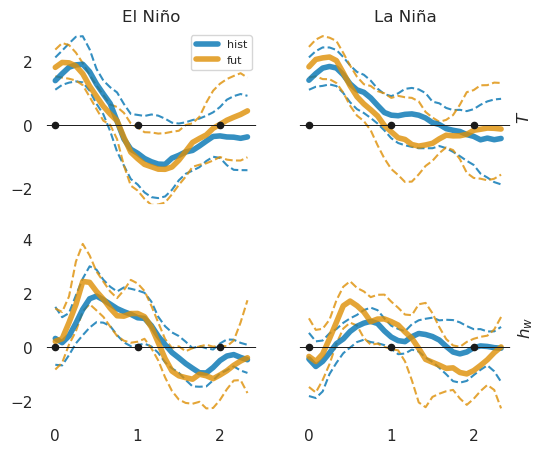

In [72]:
colors = sns.color_palette("colorblind")

fig, axs = plt.subplots(2, 2, figsize=(6, 5))

for lw, ls, q in zip([1.5, 1.5, 4], ["--", "--", "-"], [0.1, 0.9, 0.5]):

    for ci, (warm, label) in enumerate(zip([warm0, warm1], ["hist", "fut"])):
        plot_data = warm.quantile(q=q, dim="sample")
        plot_kwargs = dict(lw=lw, ls=ls, c=colors[ci], alpha=0.8)

        if not (q == 0.5):
            label = None

        axs[0, 0].plot(plot_data.lead, plot_data["T_34"], label=label, **plot_kwargs)
        axs[1, 0].plot(plot_data.lead, -plot_data["h_w"], label=label, **plot_kwargs)

    for ci, warm in enumerate([cold0, cold1]):
        plot_data = warm.quantile(q=q, dim="sample")
        plot_kwargs = dict(lw=lw, ls=ls, c=colors[ci], alpha=0.8)

        axs[0, 1].plot(plot_data.lead, -plot_data["T_34"], **plot_kwargs)
        axs[1, 1].plot(plot_data.lead, plot_data["h_w"], **plot_kwargs)

axs[0, 1].set_ylabel(r"$T$")
axs[1, 1].set_ylabel(r"$h_w$")
axs[0, 0].set_title("El Niño")
axs[0, 1].set_title("La Niña")
axs[0, 0].legend(prop=dict(size=8))
format_axs(axs)

plt.show()

Plot actual vs forecast in hist and future

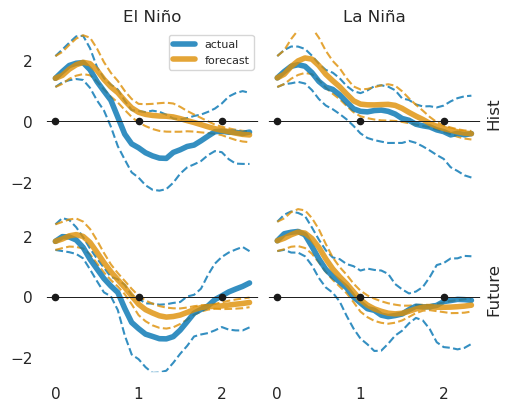

In [73]:
colors = sns.color_palette("colorblind")

fig, axs = plt.subplots(2, 2, figsize=(5, 4), layout="constrained")

for lw, ls, q in zip([1.5, 1.5, 4], ["--", "--", "-"], [0.1, 0.9, 0.5]):

    for ci, (n, label) in enumerate(zip(["T_34", "T_34_hat"], ["actual", "forecast"])):

        ## args for plotting
        sel = lambda x: x[n].quantile(q=q, dim="sample")
        plot_kwargs = dict(
            lw=lw, ls=ls, c=colors[ci], alpha=0.8, label=(label if (q == 0.5) else None)
        )

        ## plot data
        axs[0, 0].plot(warm0.lead, sel(warm0), **plot_kwargs)
        axs[1, 0].plot(warm1.lead, sel(warm1), **plot_kwargs)

        ## plot data
        axs[0, 1].plot(cold0.lead, -sel(cold0), **plot_kwargs)
        axs[1, 1].plot(cold1.lead, -sel(cold1), **plot_kwargs)


axs[0, 1].set_ylabel(r"Hist")
axs[1, 1].set_ylabel(r"Future")
axs[0, 0].set_title("El Niño")
axs[0, 1].set_title("La Niña")
axs[0, 0].legend(prop=dict(size=8))
format_axs(axs)
for ax in axs.flatten():
    ax.set_ylim([-2.5, 3])

plt.show()

Scatter plot of predictions vs actual

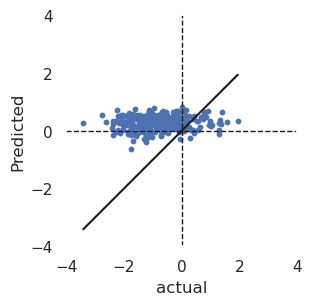

In [74]:
lead = 12

plot_data = warm0.isel(lead=lead)
plot_var = "T_34"

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_aspect("equal")

ax.scatter(
    plot_data[plot_var],
    plot_data[f"{plot_var}_hat"],
    s=10,
)

## 1-1 line
min_ = plot_data[plot_var].min().values.item()
max_ = plot_data[plot_var].max().values.item()
z = np.linspace(min_, max_)
ax.plot(z, z, c="k", lw=1.5)

## axes
kwargs = dict(ls="--", c="k", lw=1)
ax.axhline(0, **kwargs)
ax.axvline(0, **kwargs)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_xlabel("actual")
ax.set_ylabel("Predicted")

plt.show()
# ax.set_ylim

#### Floquet analysis

In [75]:
def get_L(fit, cycle_shift=np.arange(0, 1, 1 / 12)):
    """reconstruct linear operator from fit parameters and cycle (in range [0,1])"""

    ncycle = len(cycle_shift)
    ac_order = len(fit.ac_rank) - 1
    ncol = ac_order * 2 + 1
    rank_y = len(fit.ranky)
    rank_x = len(fit.rankx)
    omega = model.omega

    L_ac = np.zeros((rank_y, rank_x, ncycle))
    for i in range(rank_y):
        for j in range(rank_x):
            for m in range(ncol):

                ## dict for slicing
                sel_dict = dict(rankx=j, ranky=i, cossin=m)

                if m <= ac_order:
                    L_ac[i, j, :] = L_ac[i, j, :] + fit.Lcoef.isel(
                        sel_dict
                    ).values * np.cos(m * omega * cycle_shift)
                else:
                    mm = m - ac_order
                    L_ac[i, j, :] = L_ac[i, j, :] + fit.Lcoef.isel(
                        sel_dict
                    ).values * np.sin(mm * omega * cycle_shift)

    ## put in xarray
    cycle_coord = cycle_shift + cycle_shift[1] / 2
    L_ac = xr.DataArray(
        L_ac,
        coords=dict(ranky=fit.ranky, rankx=fit.rankx, cycle=cycle_coord),
        dims=["ranky", "rankx", "cycle"],
    )

    return L_ac


def integrate(L, x0, t0, tf, dt=1 / 2 * 1 / 365, save_hist=False, verbose=False):
    """integrate ode in time. L is a time-dependent function and
    x0 is the initial condition"""

    ## initialize and get time to integrate over
    x = x0
    time = np.arange(t0, tf, dt)

    ## define identity for convenience
    I = np.eye(2)

    ## empty array to hold results if desired
    if save_hist:
        x_hist = []

    ## integrate
    for t in tqdm.tqdm(time, disable=not (verbose)):
        x = (I + L(t) * dt) @ x

        ## save results if specified
        if save_hist:
            x_hist.append(x)

    if save_hist:
        return np.concatenate(x_hist, axis=1), time

    else:
        return x


def get_monodromy(L, dt=1 / 2 * 1 / 365, verbose=False):
    """Given time-dependent linear operator, construct monodromy matrix"""

    ## initial condition is identity matrix
    M0 = np.eye(2)

    ## integrate for one cycle
    M = integrate(L=L, x0=M0, t0=0, tf=1, dt=dt, verbose=verbose)

    return M


def get_timescales(fit, dt=1 / 365 * 1 / 2, verbose=False):
    """Get efolding timescale and period for given RO fit"""

    ## get cyclostationary operator
    L_cyc = get_L(fit, cycle_shift=np.arange(0, 1, dt))

    ## helper function to get numpy version based on time
    L_ = (
        lambda t: L_cyc.sel(cycle=t, method="nearest")
        .transpose("ranky", "rankx")
        .values
    )

    ## Get monodromy mat
    M = get_monodromy(L=L_, dt=dt, verbose=verbose)

    ## eigen-decomp
    w, _ = scipy.linalg.eig(M, left=False, right=True)

    ## get eigenvalues of linear operator
    gamma = np.log(w)
    sigma = gamma.real[0]
    omega = np.abs(gamma.imag)[0]

    ## compute timescales
    efold = -1 / sigma
    period = 2 * np.pi / omega

    return efold, period

In [76]:
## check L reconstruction works
np.allclose(get_L(fit0), fit0.Lac)
efold0, period0 = get_timescales(fit0)
efold1, period1 = get_timescales(fit1)

In [77]:
## years to loop thru
years = fits_v2.year.values[1:]

## empty list to hold results
efolds = []
periods = []

for y in tqdm.tqdm(years):
    efold, period = get_timescales(fits_v2.sel(year=y).squeeze())
    efolds.append(efold)
    periods.append(period)

efolds = np.array(efolds)
periods = np.array(periods)

100%|██████████| 21/21 [00:03<00:00,  6.45it/s]


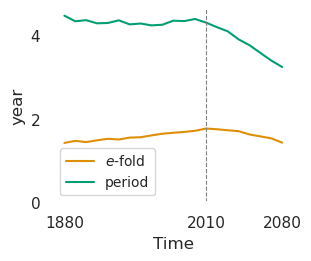

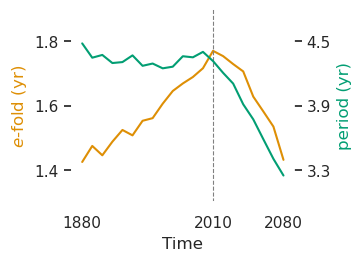

In [86]:
def format_xaxis(ax):
    """add formatting to x axis"""
    ax.set_xlabel("Time")
    ax.set_xticks([1880, 2010, 2080])
    ax.axvline(2010, ls="--", c="gray", lw=0.8)

    return


## specify colors
colors = sns.color_palette("colorblind")[1:]
# colors = [colors[i] for i in [0,2]]


### Plot 1: same scale
fig, ax = plt.subplots(figsize=(3, 2.5), layout="constrained")

ax.plot(years, efolds, label=r"$e$-fold", c=colors[0])
ax.plot(years, periods, label="period", c=colors[1])

## formatting
ax.set_ylim([0, None])
ax.set_yticks([0, 2, 4])
ax.set_ylabel("year")
ax.legend(prop=dict(size=10))
format_xaxis(ax)

plt.show()


### Plot 2: different scales
fig, ax = plt.subplots(figsize=(3.5, 2.5), layout="constrained")

ax.plot(years, efolds, label=r"$e$-fold", c=colors[0])
ax.set_yticks([1.4, 1.6, 1.8])
ax.set_ylabel(r"$e$-fold (yr)", color=colors[0])

ax2 = ax.twinx()
ax2.plot(years, periods, c=colors[1])
ax2.set_yticks([3.3, 3.9, 4.5])
ax2.set_ylabel("period (yr)", color=colors[1])

## scale axes
ax.set_ylim([1.3, 1.9])
ax2.set_ylim([3, 4.8])

format_xaxis(ax)


plt.show()

## Snapshots of seasonal changes, with variance

In [ ]:
def plot_mean_and_bounds(ax, x, show_bounds=True, **plot_kwargs):
    """print seasonal cycle of data in x on specified ax object"""

    ## plot ensemble mean
    plot_data = ax.plot(x.cycle, x.sel(posn="center"), lw=2, **plot_kwargs)

    ## plot bounds
    if show_bounds:
        kwargs = dict(c=plot_data[0].get_color(), ls="--", lw=0.5)
        for bound in ["upper", "lower"]:
            ax.plot(x.cycle, x.sel(posn=bound), **kwargs)

    return plot_data


def format_ax_and_twin(ax, ax_twin):
    """format ax as desired"""

    ax.set_title(y)
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.set_ylim([-3, 4.7])
    ax_twin.set_ylim([0, 2.2])
    ax.set_yticks([])
    ax_twin.set_yticks([])

    return

3 panels: BJ, noise, variance

In [ ]:
stats_baseline = src.utils.get_ensemble_stats(params_v2.sel(year=1880))
var_baseline = src.utils.get_ensemble_stats(Th_std.sel(year=1880)).rename(
    {"month": "cycle"}
)

## change in params between years
fig, axs = plt.subplots(1, 3, figsize=(7, 7 / 3))

## colors for different years
colors = sns.color_palette("mako")[::2]
years = [1880, 1980, 2080]
alphas = [1 / 4, 1, 1]

axs_twin = []
for j, (y, c, a) in enumerate(zip(years, colors, alphas)):

    ## twin axis for plotting variance
    axs_twin.append(axs[j].twinx())

    ## Get stats for year
    stats = src.utils.get_ensemble_stats(params_v2.sel(year=y))
    var_stats = src.utils.get_ensemble_stats(Th_std.sel(year=y)).rename(
        {"month": "cycle"}
    )

    ## plot baselines
    kwargs = dict(show_bounds=False, alpha=1 / 3)
    plot_mean_and_bounds(axs[j], x=stats_baseline["BJ_ac"], c="k", **kwargs)
    plot_mean_and_bounds(
        axs[j], x=stats_baseline["xi_T_norm"], c="k", ls="--", **kwargs
    )
    plot_mean_and_bounds(axs_twin[j], x=var_baseline["T_34"], c="r", **kwargs)

    ## get stats for new period
    plot_mean_and_bounds(axs[j], x=stats["BJ_ac"], c="k", alpha=a, label=r"$BJ$")
    plot_mean_and_bounds(
        axs[j], x=stats["xi_T_norm"], ls="--", c="k", alpha=a, label=r"$\xi_T/\sigma_T$"
    )
    plot_mean_and_bounds(
        axs_twin[j], x=var_stats["T_34"], c="r", alpha=a, label=r"$\sigma(T)$"
    )

    ## format axes
    format_ax_and_twin(axs[j], axs_twin[j])

axs[-1].legend(prop=dict(size=6), loc="upper right")
axs[0].set_yticks([-2, 0, 2, 4])
axs[0].set_ylabel(r"year$^{-1}$")
axs_twin[-1].set_yticks([0, 1], labels=[0, 1], color="r")
axs_twin[-1].set_ylabel(r"$\sigma_T$ ($^{\circ}$C)", color="r")

plt.show()

## Growth rate and noise vs variance
(need ensemble of parameters to do this...)

Function to format plot

In [ ]:
def format_ax(ax):
    """add guidelines and labels"""
    ax.axvline(0, c="k", lw=0.5)
    ax.axhline(0, c="k", lw=0.5)
    ax.set_xticks([-0.4, 0, 0.4, 0.8])
    ax.set_yticks([0, 35, 70])
    ax.set_xlabel(r"$\Delta ~\overline{BJ}$ (year$^{-1}$)")
    ax.set_ylabel(r"$\Delta \sigma_T$ (%)")
    return

compute relative change in variance (normalize each model separately)

In [ ]:
baseline = Th_std.isel(year=0)
delta_Th_std_relative = 100 * (Th_std - baseline) / baseline

Make plot

In [ ]:
## get data for plot
x0 = delta_params_v2["BJ_ac"].sel(year=2080).mean("cycle")
x1 = delta_params_v2["xi_T"].sel(year=2080).mean("cycle")
y = delta_Th_std_relative["T_34"].sel(year=2080).mean("month")

## compute correlation
corr0, pval0 = scipy.stats.pearsonr(x0.values, y.values)
corr1, pval0 = scipy.stats.pearsonr(x1.values, y.values)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2))

## scatter plot preferences
scatter_kwargs = dict(zorder=10, s=10)

## plot data (BJ) and label
axs[0].scatter(x0, y, **scatter_kwargs)
axs[0].set_title(f"$r=${corr0:.2f}")
axs[0] = format_ax(axs[0])

## plot data (noise) and label
axs[1].scatter(x1, y, **scatter_kwargs)
axs[1].set_title(f"$r=${corr1:.2f}")

## label 2nd axis
format_ax(axs[1])
axs[1].set_yticks([])
axs[1].set_ylabel(None)
axs[1].set_xlabel(r"$\Delta\xi_T$ (K year$^{-1}$)")

plt.show()

## Supplementary

#### Parameter estimates from individual ensemble members

In [ ]:
## param to plot
p = "epsilon"

fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout="constrained")

param_names = ["R", "xi_T_norm", "epsilon", "xi_h_norm"]
titles = [r"$R$", r"$\xi_T$", r"$\varepsilon$", r"$\xi_h$"]

for p, title, ax in zip(param_names, titles, axs.flatten()):

    ax.set_title(title)

    ## plot ensemble members
    for i, m in enumerate(params_v2.member.values):

        label = "Ensemble members" if (i == 50) else None

        ax.plot(
            params_v2.year,
            delta_params_v2[p].sel(member=m).mean("cycle"),
            c="gray",
            alpha=0.5,
            lw=0.5,
        )

    ## plot ensemble mean
    ax.plot(
        params_v2.year,
        delta_params_v2[p].mean(["member", "cycle"]),
        c="k",
        lw=2,
        label="Ensemble mean",
    )

    ## set axis specs
    ax.set_ylim([-2, 2])
    ax.axhline(0, c="k", ls="--", lw=1)
    ax.set_xticks([])

## format
for ax in axs[1, :]:
    ax.set_xlabel("Time")
    ax.set_xticks([1870, 1975, 2080])
for ax in axs[:, 0]:
    ax.set_ylabel(r"Growth rate (yr$^{-1}$)")

plt.show()